# Forward & Inverse modelling ERT with pyGimli

Here we take a look at forward modelling a layered earth, then inverting the forward modelling result first without
constraints, then with some layer definitions. With much thanks to the folks behind [pyGimli](https://www.pygimli.org/).

First, load up some packages. We need to have pygimli & numpy in addition to standard python installation, and reference
the exampledata folder if we want to pick up field data for electrode configurations.

In [1]:
import pygimli as pg
import numpy as np
import os, sys
from pygimli.physics import ert
import pygimli.meshtools as mt

## Create the electrode scheme and model

Firstly, create a 'scheme' of electrode locations to integrate into the world mesh later.

This setup creates a 21-point dipole-dipole array of electrodes every 5m from `x=0` to `x=100`.

Other preset configurations include Wenner, `'wa'`, Schlumberger `'slm'` and pole-dipole `'pd'`. To trigger a list, run the
cell with the `schemeName` set to an unrecognised scheme, e.g. `'abc'`.\

In [2]:
scheme = ert.createData(elecs=np.linspace(start=0, stop=100, num=21), schemeName='dd')

Next, create a 'world' with layers, bodies, etc and display it. This currently creates a 'world' from `x=-50m` to `x-150m` and `y=0m` to `y=-100m`, with 2 layers at 2m and 10m depth overlying a halfspace.

(<Axes: >, None)

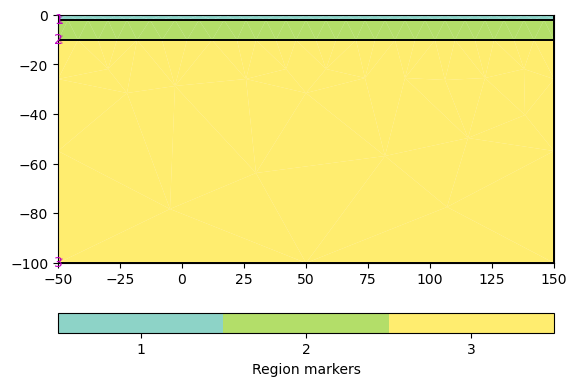

In [6]:
world = mt.createWorld(start=[-50., 0.], end=[150., -100.], layers=[-2., -10.], worldMarker=True)
pg.show(world)

It's also possible to define circles, rectangles and polygons with the pygimli meshtools, then add them to the 'world' 
arithmetically, e.g. `world += block`. Full details of arguments at [pygimli.meshtools](https://www.pygimli.org/pygimliapi/_generated/pygimli.meshtools.html#module-pygimli.meshtools)

Some examples:
```
block = mt.createCircle(pos=[25, -3.], radius=[4, 1], marker=4, boundaryMarker=10, area=0.1)

poly = mt.createPolygon([(11,-4), (12,-1.5), (14,-2), (15,-2), (18,-3), (15,-3.5), (13,-4.5)],
                        isClosed=True, addNodes=3, interpolate='spline', marker=5)
                        
rect = mt.createRectangle(start = [55,-4], end = [60,-10], marker=6)
```

## Create mesh for earth model & electrode locations

Next, create the mesh within the 'world' for the earth model. The electrode scheme defines nodes in the mesh (with additional
nodes at 1/10 spacing on recommendations from pyGimli devs). We then define a resistivity mapping for the three layers, and 
display the model.

(-25.0, 0.0)

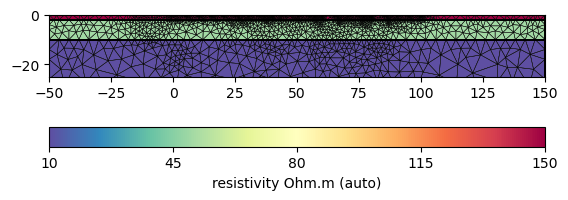

In [7]:
for p in scheme.sensors():
    world.createNode(p)
    world.createNode(p - [0, 0.1])

mesh = mt.createMesh(world, quality=34)

rhomap = [[1,150.],[2,50.],[3,10.]]

ax, _ = pg.show(mesh, data=rhomap, label=pg.unit('resistivity Ohm.m'),
                showMesh=True, cMap="Spectral_r")
ax.set_ylim(-25,0)

## Run the forward model & display result

06/06/24 - 14:11:20 - pyGIMLi - INFO - Data error estimate (min:max)  0.01000115552626389 : 0.020267281164265894
06/06/24 - 14:11:20 - pyGIMLi - INFO - 0.14856785665823347 503.7307670788183
06/06/24 - 14:11:20 - pyGIMLi - INFO - Simulated data Data: Sensors: 21 data: 171, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
06/06/24 - 14:11:20 - pyGIMLi - INFO - The data contains: ['a', 'b', 'err', 'i', 'ip', 'iperr', 'k', 'm', 'n', 'r', 'rhoa', 'u', 'valid']
06/06/24 - 14:11:20 - pyGIMLi - INFO - Simulated rhoa (min/max) 10.238745878719232 82.59801887694921
06/06/24 - 14:11:20 - pyGIMLi - INFO - Selected data noise %(min/max) 1.000115552626389 2.0267281164265896


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x25836ad3850>)

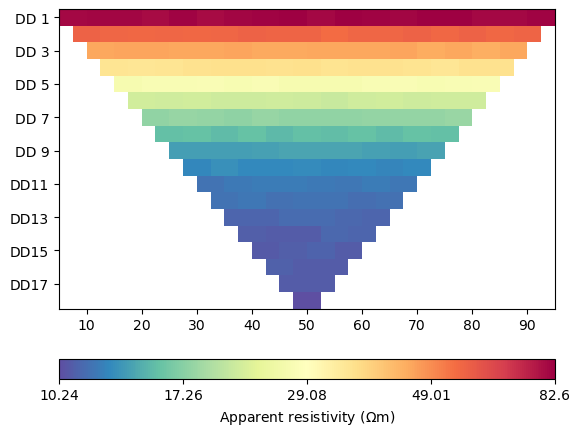

In [11]:
fwddata = ert.simulate(mesh, scheme=scheme, res=rhomap, noiseLevel=1,
                    noiseAbs=1e-6, seed=1337)

# set information fields
pg.info(np.linalg.norm(fwddata['err']), np.linalg.norm(fwddata['rhoa']))
pg.info('Simulated data', fwddata)
pg.info('The data contains:', fwddata.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(fwddata['rhoa']), max(fwddata['rhoa']))
pg.info('Selected data noise %(min/max)', min(fwddata['err'])*100, max(fwddata['err'])*100)

ert.show(fwddata)

## Run inversion of forward modelled output

First inversion test is completely open with automated mesh definition, and no constraints.

06/06/24 - 14:27:44 - pyGIMLi - INFO - Found 2 regions.
06/06/24 - 14:27:44 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
06/06/24 - 14:27:44 - pyGIMLi - INFO - Found 2 regions.
06/06/24 - 14:27:44 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
06/06/24 - 14:27:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
06/06/24 - 14:27:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
06/06/24 - 14:27:44 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 997 Cells: 1848 Boundaries: 1458
06/06/24 - 14:27:44 - pyGIMLi - INFO - Use median(data values)=21.751261927787098
06/06/24 - 14:27:44 - pyGIMLi - INFO - Created startmodel from forward operator: 287, min/max=21.751262/21.751262
06/06/24 - 14:27:44 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000025836865800>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000258368661B0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000025836864360>
min/max (data): 10.24/82.6
min/max (error): 1%/2.03%
min/max (start model): 21.75/21.75
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 4190.42
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  456.06 (dPhi = 89.05%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    2.02 (dPhi = 98.86%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    1.82 (dPhi = 3.86%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    1.80 (dPhi = 0.45%) lam: 20.0
############

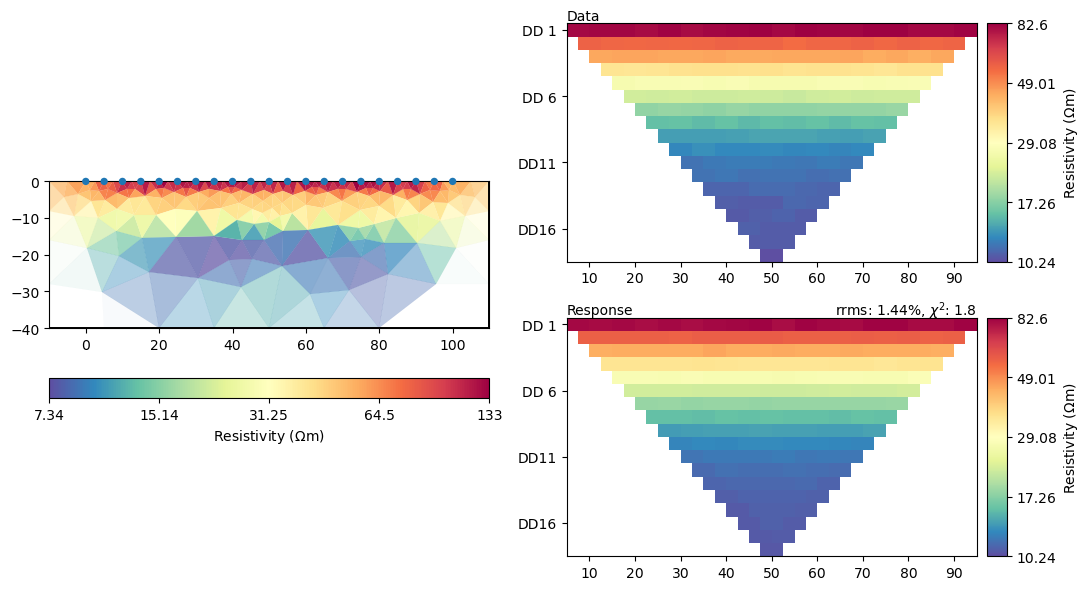

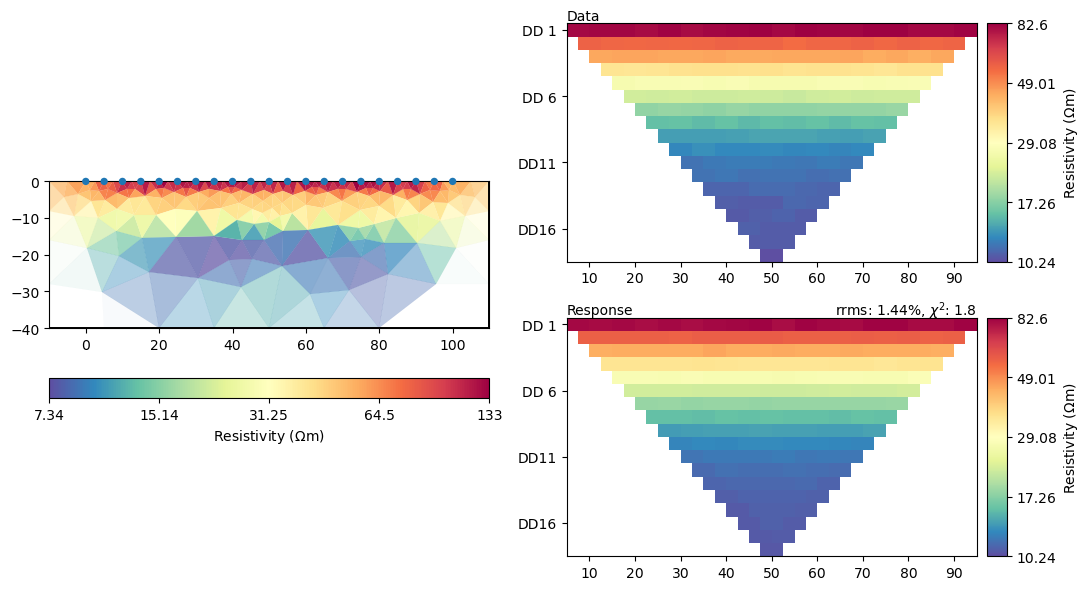

In [15]:
mgr = ert.ERTManager(fwddata)

inv = mgr.invert(lam=20, verbose=True)
# np.testing.assert_approx_equal(mgr.inv.chi2(), 0.7, significant=1) # Not sure what this does, taken from pyGimli example

# plot inversion result with input/output pseudosections
mgr.showResultAndFit()

# plot just inversion result with fixed axis limits
# ax, _ = mgr.showResult(xlabel="x (m)", ylabel="z (m)", cMap="Spectral_r")
# ax.set_xlim(-10,110)

## Inversion with layer boundaries

If we have confidence on the depth of layer interfaces, we can include them in the definition of a mesh for the inversion,
with dramatic results.

Create a similar 'world' with two horizontal lines:

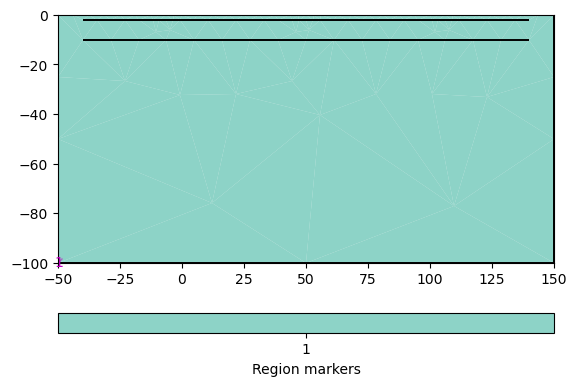

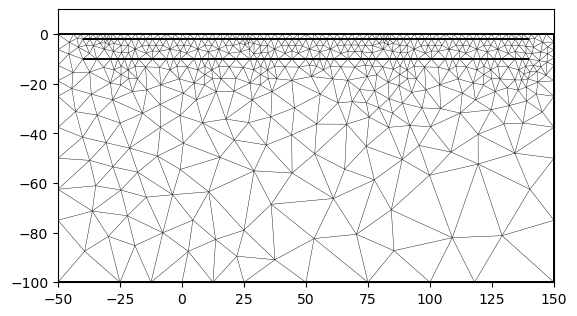

In [17]:
geo = mt.createWorld(start=[-50., 0.], end=[150., -100.], worldMarker=True)
line1 = pg.meshtools.createLine(start=[-40, -2], end=[140, -2], marker=2) # marker>0 means it functions as a constraint
line2 = pg.meshtools.createLine(start=[-40, -10], end=[140, -10], marker=3) # marker>0 means it functions as a constraint

geo += line1 + line2

pg.show(geo)

invmesh = pg.meshtools.createMesh(geo, quality=34, size=1.)
ax, _ = pg.show(invmesh)
ax.set_xlim(-50, 150);
ax.set_ylim(-100, 10);

Now re-run the inversion and display...

06/06/24 - 14:33:21 - pyGIMLi - INFO - Found 1 regions.
06/06/24 - 14:33:21 - pyGIMLi - INFO - Creating forward mesh from region infos.
06/06/24 - 14:33:21 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
06/06/24 - 14:33:21 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2066 Cells: 3924 Boundaries: 3046
06/06/24 - 14:33:21 - pyGIMLi - INFO - Use median(data values)=21.751261927787098
06/06/24 - 14:33:21 - pyGIMLi - INFO - Created startmodel from forward operator: 981, min/max=21.751262/21.751262
06/06/24 - 14:33:21 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000002583ECA8B30>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000002583EACFBF0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000002583ECAA660>
min/max (data): 10.24/82.6
min/max (error): 1%/2.03%
min/max (start model): 21.75/21.75
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 4055.35
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  142.46 (dPhi = 96.48%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    7.05 (dPhi = 94.95%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    0.61 (dPhi = 89.46%) lam: 20.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.61)    

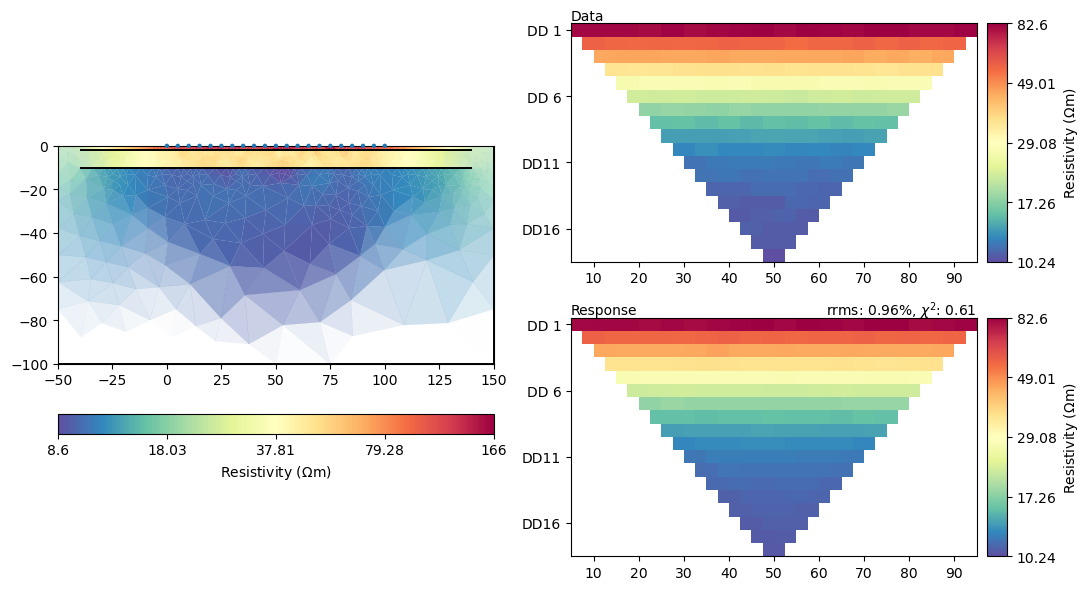

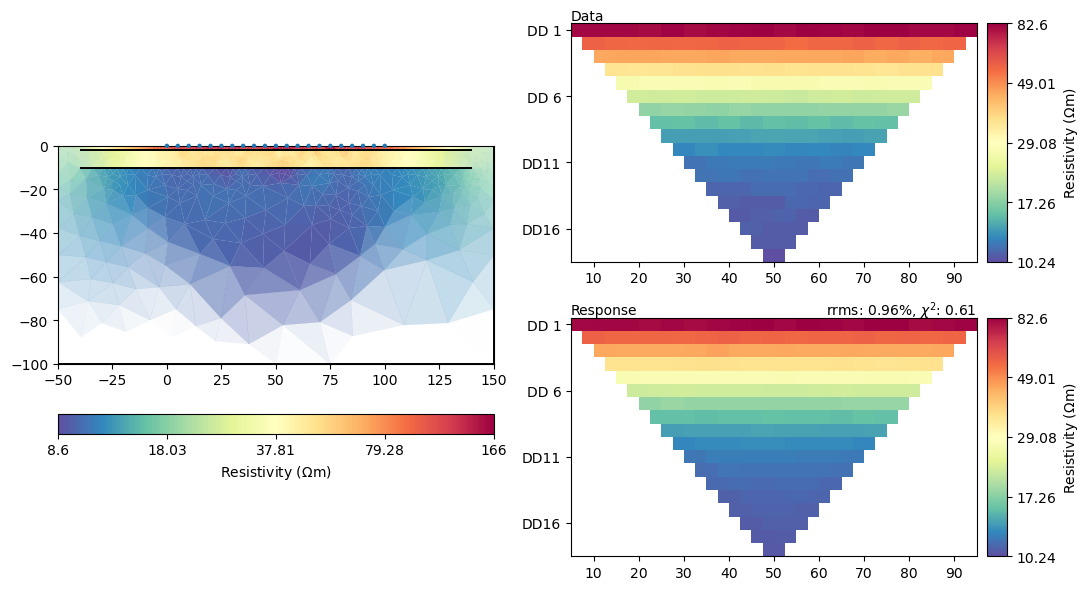

In [18]:
mgrConstrained = ert.ERTManager(fwddata)
coninv = mgrConstrained.invert(verbose=True, lam=20, mesh=invmesh)

mgrConstrained.showResultAndFit()

Finally, we can display both versions of the inversion, with the original 'world' for comparison

(-40.0, 0.0)

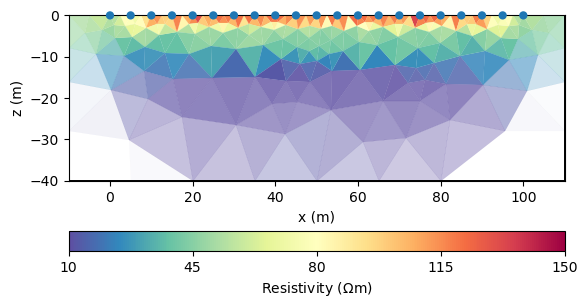

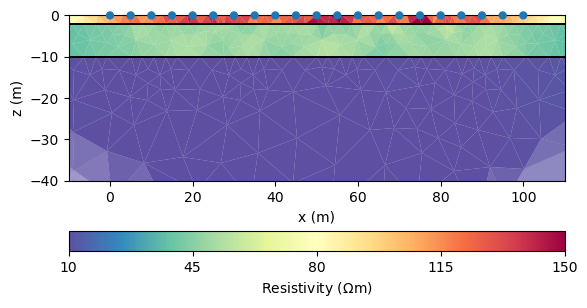

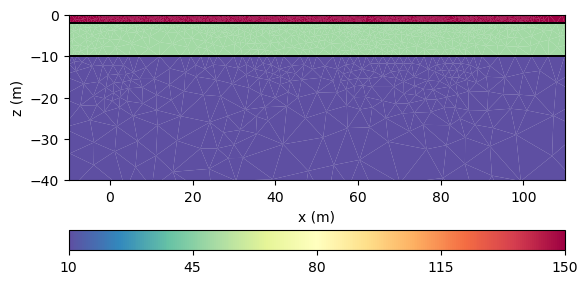

In [25]:
kwargs = {'xlabel':"x (m)", 'ylabel':"z (m)", 'cMap':"Spectral_r", 'cMin':10, 'cMax':150, 'logScale':False}

ax, _ = mgr.showResult(**kwargs)
ax.set_xlim(-10,110)
ax.set_ylim(-40,0)

ax, _ = mgrConstrained.showResult(**kwargs)
ax.set_xlim(-10,110)
ax.set_ylim(-40,0)

ax, _ = pg.show(mesh, data=rhomap, showMesh=False, **kwargs)
ax.set_xlim(-10,110)
ax.set_ylim(-40,0)